# Pneumonia prediction



## Credits

Rishit - [Twitter](https://twitter.com/rishit_dagli)


## Know the dataset

Context

http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

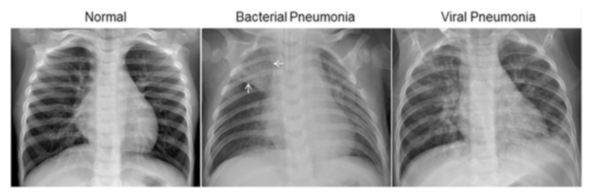

Figure S6. Illustrative Examples of Chest X-Rays in Patients with Pneumonia, Related to Figure 6
The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.
http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

Content

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.
Acknowledgements

Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

License: CC BY 4.0

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

## Some Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

import os
import numpy as np
import pandas as np

import matplotlib.pyplot as plt
%matplotlib inline

## Let's now see all the availaible files

In [ ]:
print(os.listdir("../input/chest-xray-pneumonia/chest_xray"))

print(os.listdir("../input/chest-xray-pneumonia/chest_xray/train"))

Let's now take 2 images from the dataset at random and see them, to get an idea about the data

In [ ]:
img_name = 'NORMAL2-IM-0588-0001.jpeg'
img_normal = load_img('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/' + img_name)

print('NORMAL')
plt.imshow(img_normal)
plt.show()

In [ ]:
img_name = 'person63_bacteria_306.jpeg'
img_pneumonia = load_img('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/' + img_name)

print('PNEUMONIA')
plt.imshow(img_pneumonia)
plt.show()

## Loading data

First specify the image height and width

In [ ]:
img_width, img_height = 150, 150

Now let's specify our directory names and some hyperparameters

In [ ]:
train_data_dir = '../input/chest-xray-pneumonia/chest_xray/train'
validation_data_dir = '../input/chest-xray-pneumonia/chest_xray/val'
test_data_dir = '../input/chest-xray-pneumonia/chest_xray/test'

nb_train_samples = 5217
nb_validation_samples = 17
epochs = 20
batch_size = 16

In [ ]:
input_shape = (img_width, img_height, 3)

## Model

Here is the model I created please feel free to experiment with it and play around and have fun :)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

### Model summaries

This code peice is something which I have discovered pretty recently and is wonderful, it just prints out all your layers unlike `model.summary()` it does not need to be compiled first

In [ ]:
model.layers

This is the input shape our model expects

In [ ]:
model.input

As we are doing binary classification we will have 1 neuron giving values between 0  and 1

In [ ]:
model.output

I have a pretty good experience with `RMSprop` for images but feel free to experiment with these-

* Adam (does not work that well)
* Adagrad
* Adadelta

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Getting our data in

### Augmentation

We will first augment our images, made very easy with TensorFlow `ImageDataGenerator`.

It's super simple as simple as just passing in the values and name

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

Don't augment the test samples!

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

Once we are done with augmentation let's load images

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

In [ ]:
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

## Finally train model

At the time this notebook was made `model.fit_generator` was widely used. It is scheduled to be deprecated, in so case please use `model.fit()`

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

### Save model`s weights

This step is not at all mandatory but lets make a reference 

In [ ]:
model.save_weights('model.h5')

## Evaluating our model

Lets see the accuracy first

In [ ]:
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

And now let's make a plot

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

## Conclusion

Neural Networks, CNNs gave us a very good accuracy, we first augmented our images with the `ImageDataGenerator` and then we loaded our images into the runtime. We then created a model which was pretty good.